In [68]:
import pandas as pd
from pyathena import connect
from sklearn.preprocessing import OneHotEncoder
import awswrangler as wr
%run 'functions.ipynb'
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
query = """
select * from prq_ptoc_em_1m_training_b where (target = 0 or (target =1 and reasoncode<>'Z')) and RandP is null and plan_tenure>0 and poc=12 and gross<>0;
""" 
df_raw = wr.athena.read_sql_query(sql=query
                              , database="sam_mccouig_db"
                             ,data_source='AwsDataCatalog')

In [33]:
feats_to_drop = [
        "cmk",
        "cocode",
        "schcode",
        "planno",
        # "dedupeapplcode",
        # "reptypesum",
        # "productcode",
        # "routetomarket",
        # "touchpoint",
        "poc",
        "lookupdate",
        # "productcode",
        "writeoff",
        "sub",
        "month_to_renewal_delete",
        "renewaldate_new",
        # "target",
        "randp",
        "reasoncode",
        "reasondescription"
    ]

In [34]:
df_raw.shape

(4632967, 58)

In [35]:
df_raw.columns.to_list()

['cmk',
 'cocode',
 'schcode',
 'planno',
 'renewaldate_new',
 'poc',
 'lookupdate',
 'gross',
 'ageofapp',
 'productcode',
 'writeoff',
 'target',
 'sub',
 'valuegroup',
 'plan_tenure',
 'month_to_renewal_new',
 'month_to_renewal_delete',
 'renfee_new',
 'cust_tenure',
 'age',
 'affluence',
 'employmentstatus',
 'journeycomplexity_sum',
 'reg_1m',
 'reg_12m',
 'reg_3y',
 'offer_ob_1m',
 'offer_ob_12m',
 'offer_ob_3y',
 'offer_not_ob_1m',
 'offer_not_ob_12m',
 'offer_not_ob_3y',
 'comp_1m',
 'comp_12m',
 'comp_3y',
 'claims_1m',
 'claims_12m',
 'claims_3y',
 'calls_ob_1m',
 'calls_ob_12m',
 'calls_ob_3y',
 'calls_ib_1m',
 'calls_ib_12m',
 'calls_ib_3y',
 'no_pur_plan_12m',
 'no_can_plan_12m',
 'randp',
 'reasoncode',
 'reasondescription',
 'routetomarket',
 'touchpoint',
 'dedupeapplcode',
 'reptypesum',
 'claimsthisperiod',
 'totalclaimsamount',
 'avgclmnt',
 'suminsured',
 'avgclmnt_to_sumins']

In [36]:
df = df_raw.drop(feats_to_drop, axis=1)
df.columns.to_list()

['gross',
 'ageofapp',
 'productcode',
 'target',
 'valuegroup',
 'plan_tenure',
 'month_to_renewal_new',
 'renfee_new',
 'cust_tenure',
 'age',
 'affluence',
 'employmentstatus',
 'journeycomplexity_sum',
 'reg_1m',
 'reg_12m',
 'reg_3y',
 'offer_ob_1m',
 'offer_ob_12m',
 'offer_ob_3y',
 'offer_not_ob_1m',
 'offer_not_ob_12m',
 'offer_not_ob_3y',
 'comp_1m',
 'comp_12m',
 'comp_3y',
 'claims_1m',
 'claims_12m',
 'claims_3y',
 'calls_ob_1m',
 'calls_ob_12m',
 'calls_ob_3y',
 'calls_ib_1m',
 'calls_ib_12m',
 'calls_ib_3y',
 'no_pur_plan_12m',
 'no_can_plan_12m',
 'routetomarket',
 'touchpoint',
 'dedupeapplcode',
 'reptypesum',
 'claimsthisperiod',
 'totalclaimsamount',
 'avgclmnt',
 'suminsured',
 'avgclmnt_to_sumins']

In [37]:
# reduce cardinality of certain categorical features

cat_features = [f for f in df.select_dtypes(include=['string']).columns.sort_values()]

to_group = list(cat_features)
# for i in to_group:
#     print(f'{i}:{df[i].nunique()}')
to_group

['dedupeapplcode', 'productcode', 'reptypesum', 'routetomarket', 'touchpoint']

In [38]:
cat_feats1= ['affluence', 'employmentstatus', 'valuegroup']

In [39]:
cat_features = cat_features + cat_feats1
cat_features

['dedupeapplcode',
 'productcode',
 'reptypesum',
 'routetomarket',
 'touchpoint',
 'affluence',
 'employmentstatus',
 'valuegroup']

In [41]:
df['row']=1
df['row'].sum()

4632967

In [46]:
for i in cat_features:
    print(i, df[i].nunique())

dedupeapplcode 12
productcode 11
reptypesum 10
routetomarket 7
touchpoint 4
affluence 6
employmentstatus 5
valuegroup 5


In [47]:
group_low_freq(df=df, lst= cat_features, pct=2.5) # regroup very low frequency classes

In [48]:
for i in cat_features:
    print(i, df[i].nunique())

dedupeapplcode 12
productcode 11
reptypesum 10
routetomarket 7
touchpoint 4
affluence 5
employmentstatus 3
valuegroup 5


In [50]:
df.valuegroup.unique()

array([4, 1, 3, 2, -1, <NA>], dtype=object)

<Figure size 432x288 with 0 Axes>

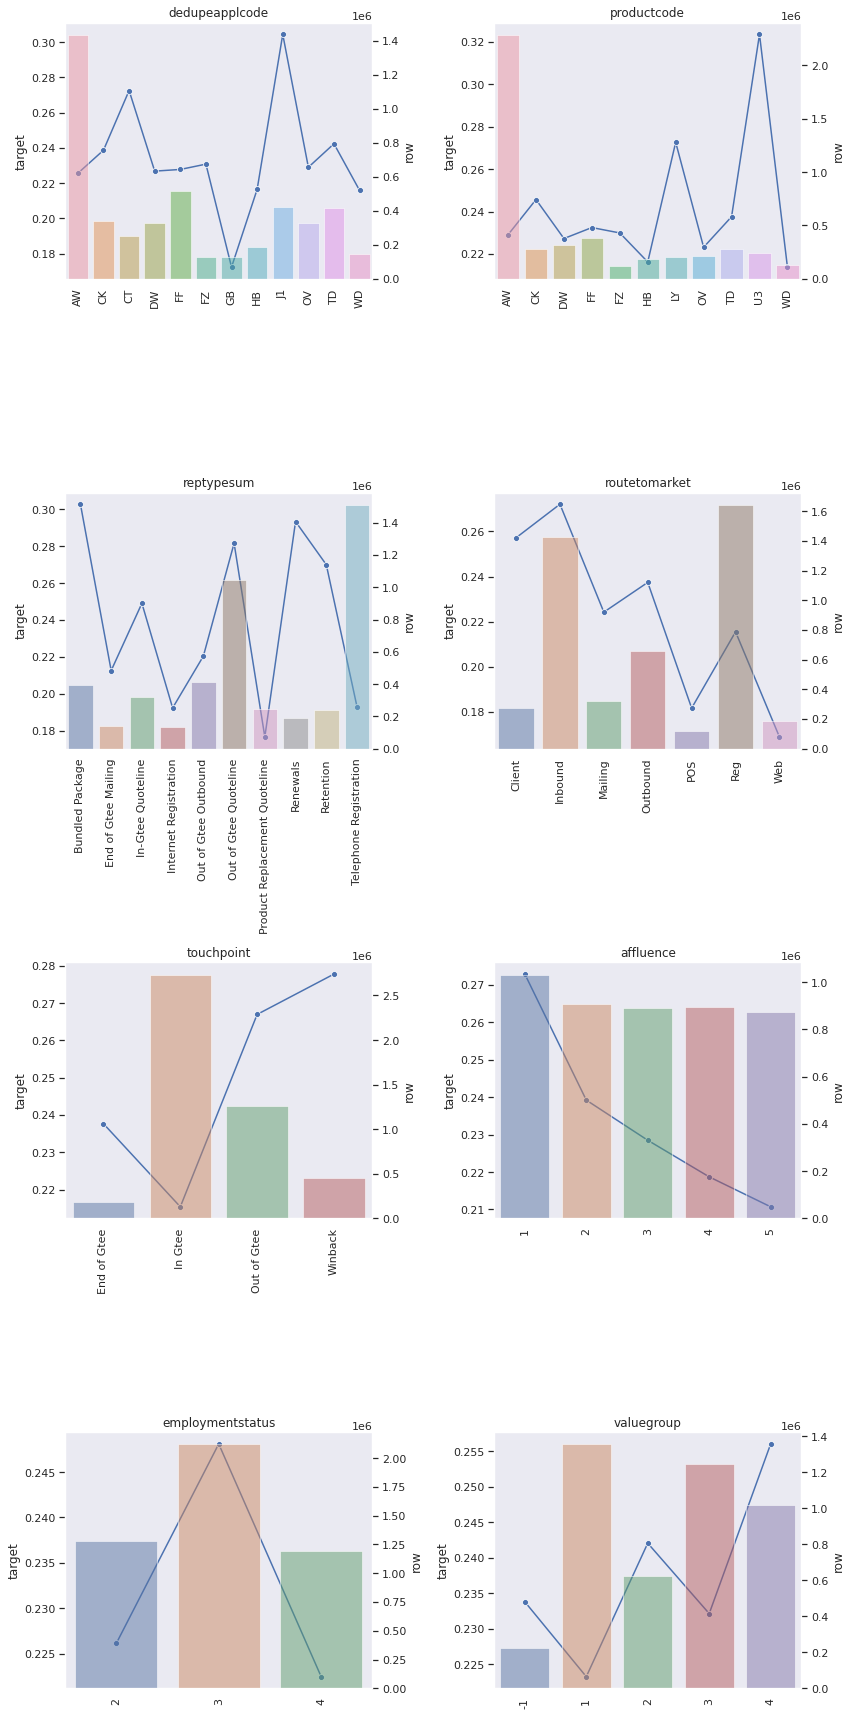

In [69]:
cat_plot_no_pred(df, cat_features, 4, 2, 'target', 'row', target_lim = None)

In [60]:
num_features = list(set(df.columns)-set(cat_features))
num_features.remove('row')
num_features.remove('target')
num_features

['claims_3y',
 'calls_ob_12m',
 'calls_ib_12m',
 'comp_3y',
 'no_can_plan_12m',
 'cust_tenure',
 'gross',
 'claims_12m',
 'reg_3y',
 'journeycomplexity_sum',
 'claimsthisperiod',
 'offer_not_ob_12m',
 'plan_tenure',
 'comp_1m',
 'no_pur_plan_12m',
 'totalclaimsamount',
 'avgclmnt_to_sumins',
 'reg_12m',
 'calls_ob_3y',
 'reg_1m',
 'claims_1m',
 'calls_ib_3y',
 'offer_ob_3y',
 'age',
 'suminsured',
 'offer_not_ob_3y',
 'offer_ob_1m',
 'avgclmnt',
 'comp_12m',
 'offer_ob_12m',
 'offer_not_ob_1m',
 'calls_ob_1m',
 'ageofapp',
 'renfee_new',
 'calls_ib_1m',
 'month_to_renewal_new']

In [61]:
len(num_features)

36

<Figure size 432x288 with 0 Axes>

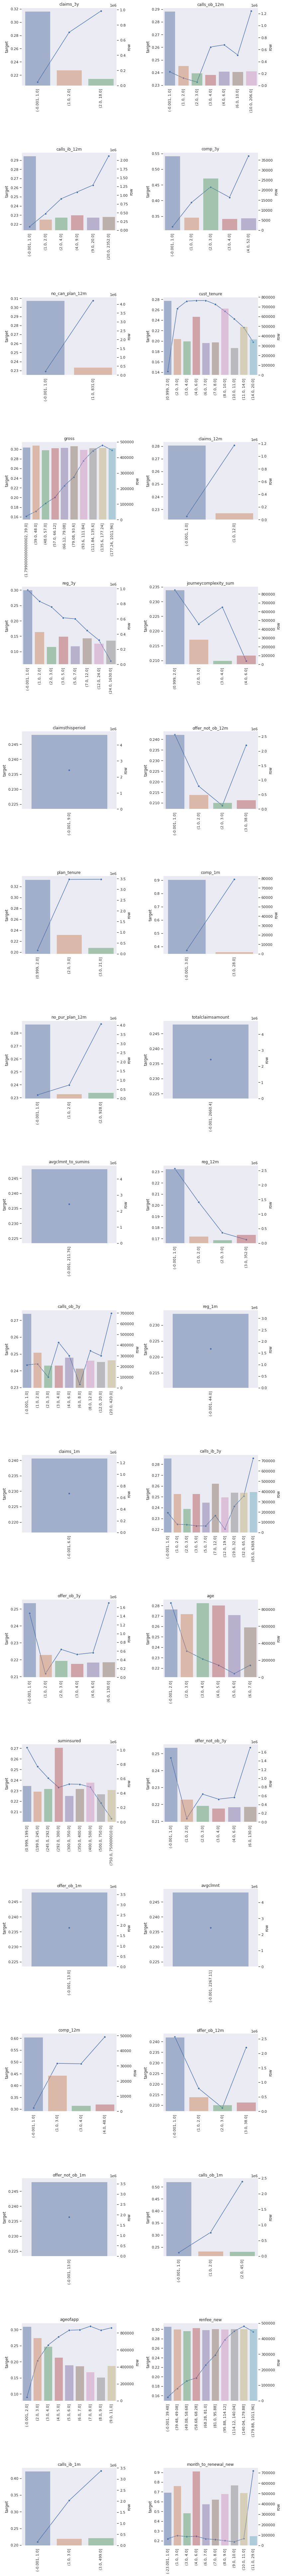

In [70]:
num_plot_no_pred(df, num_features, 18, 2, 'target', 'row', nbins=10, target_lim = None)

In [ ]:
########## Dummies             ##########
df["dedupeapplcode2"] = pd.factorize(df["dedupeapplcode"])[0]
df["reptypesum2"] = pd.factorize(df["reptypesum"])[0]
df["productcode2"] = pd.factorize(df["productcode"])[0]
df["routetomarket2"] = pd.factorize(df["routetomarket"])[0]
df["touchpoint2"] = pd.factorize(df["touchpoint"])[0]
########## OHE                 ##########
ohe = OneHotEncoder(dtype=int)
df[ohe.get_feature_names_out()] = ohe.fit_transform(df[['routetomarket']]).toarray()
df[ohe.get_feature_names_out()] = ohe.fit_transform(df[['touchpoint']]).toarray()
df.dtypes